In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def dice(a, b):
    inter = np.logical_and(a > 0, b > 0).sum()
    return 2 * inter / (a.sum() + b.sum())

def get_rotated_bounds(image, transform):
    """Compute bounding box that fully contains rotated image."""
    size = np.array(image.GetSize())
    spacing = np.array(image.GetSpacing())
    origin = np.array(image.GetOrigin())
    direction = np.array(image.GetDirection()).reshape(3,3)
    
    # 8 corners in physical space
    corners = []
    for k in [0, size[2]]:
        for j in [0, size[1]]:
            for i in [0, size[0]]:
                idx = np.array([i, j, k])
                corner_phys = origin + direction @ (idx * spacing)
                corners.append(corner_phys)
    
    # Transform corners
    corners_rot = [np.array(transform.TransformPoint(tuple(c))) for c in corners]
    
    # Get bounding box
    min_corner = np.min(corners_rot, axis=0)
    max_corner = np.max(corners_rot, axis=0)
    
    new_origin = min_corner
    new_size = np.ceil((max_corner - min_corner) / spacing).astype(int)
    return new_origin, new_size


In [2]:
ct = sitk.ReadImage(r"Z:\FacialDeformation_MPhys\paired_data\nina_abby\UIDQQ0Q00Q910\CT_WHOLE_CNS_cropped.nii")
seg = sitk.ReadImage(r"Z:\FacialDeformation_MPhys\paired_data\nina_abby\UIDQQ0Q00Q910\mandible.nii.gz")


In [3]:
# Define transform (rotate around z-axis)
angle = 35  # Change as needed
tx = sitk.Euler3DTransform()
tx.SetRotation(0, 0, np.deg2rad(angle))
tx.SetCenter(np.array(ct.TransformContinuousIndexToPhysicalPoint(np.array(ct.GetSize())/2)))

# Compute new bounding box
new_origin, new_size = get_rotated_bounds(ct, tx)

# Resample CT
resampled_ct = sitk.Resample(
    ct,
    size=list(map(int, new_size)),
    transform=tx,
    interpolator=sitk.sitkLinear,
    outputOrigin=new_origin.tolist(),
    outputSpacing=ct.GetSpacing(),
    outputDirection=ct.GetDirection(),
    defaultPixelValue=0.0,
    outputPixelType=ct.GetPixelID()
)

# Resample segmentation (nearest-neighbor)
resampled_seg = sitk.Resample(
    seg,
    size=list(map(int, new_size)),
    transform=tx,
    interpolator=sitk.sitkNearestNeighbor,
    outputOrigin=new_origin.tolist(),
    outputSpacing=seg.GetSpacing(),
    outputDirection=seg.GetDirection(),
    defaultPixelValue=0,
    outputPixelType=seg.GetPixelID()
)

# Save both
out_dir = r"Z:\FacialDeformation_MPhys\paired_data\nina_abby\UIDQQ0Q00Q910\Resampled\seg_rot_35"
sitk.WriteImage(resampled_ct, f"{out_dir}\\CT_WHOLE_CNS_cropped_resampled_transformed.nii.gz")
sitk.WriteImage(resampled_seg, f"{out_dir}\\mandible_transformed.nii.gz")


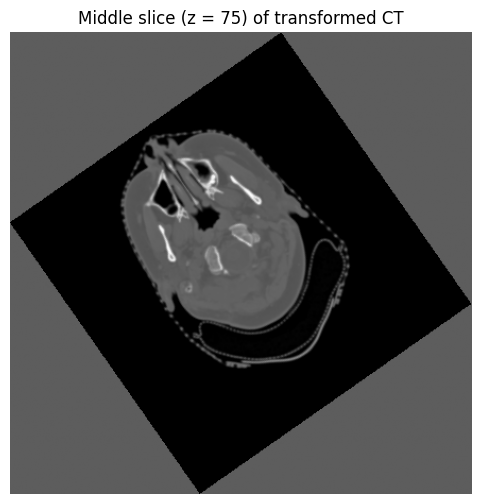

In [4]:
ct_array = sitk.GetArrayFromImage(resampled_ct)
mid_slice = ct_array.shape[0] // 2
plt.figure(figsize=(6, 6))
plt.imshow(ct_array[mid_slice, :, :], cmap='gray')
plt.title(f"Middle slice (z = {mid_slice}) of transformed CT")
plt.axis('off')
plt.show()


In [5]:
from totalsegmentator.python_api import totalsegmentator

def main():
    input_path = r"Z:\FacialDeformation_MPhys\paired_data\nina_abby\UIDQQ0Q00Q910\Resampled\seg_rot_35\CT_WHOLE_CNS_cropped_resampled_transformed.nii.gz"
    output_path = r"Z:\FacialDeformation_MPhys\paired_data\nina_abby\UIDQQ0Q00Q910\Resampled\seg_rot_35"

    totalsegmentator(input_path, output_path, task='craniofacial_structures')
    print('\nDone!')

if __name__ == "__main__":
    main()



If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough segmentation for cropping...
Resampling...
  Resampled in 2.18s
Predicting...


100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


  Predicted in 29.28s
Resampling...
  cropping from (435, 435, 150) to (214, 214, 118)
Resampling...
  Resampled in 29.94s
Predicting...


100%|██████████| 240/240 [02:56<00:00,  1.36it/s]


  Predicted in 233.02s
Resampling...
Saving segmentations...
  Saved in 26.36s

Done!


In [6]:
# Read predicted segmentation from TotalSegmentator
seg_pred = sitk.ReadImage(r"Z:\FacialDeformation_MPhys\paired_data\nina_abby\UIDQQ0Q00Q910\Resampled\seg_rot_35\mandible.nii.gz")

# Compute inverse transform (rotate back)
tx_inv = tx.GetInverse()

# Resample predicted segmentation back to original CT grid
seg_pred_back = sitk.Resample(
    seg_pred,
    referenceImage=ct,
    transform=tx_inv,
    interpolator=sitk.sitkNearestNeighbor,
    defaultPixelValue=0,
    outputPixelType=seg_pred.GetPixelID()
)

# Compute Dice score
arr1 = sitk.GetArrayFromImage(seg > 0)
arr2 = sitk.GetArrayFromImage(seg_pred_back > 0)
print("Overall Dice:", dice(arr1, arr2))


Overall Dice: 0.9502362104187947


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

ct_img = nib.load(r"Z:\FacialDeformation_MPhys\paired_data\nina_abby\UIDQQ0Q00Q910\Resampled\CT_WHOLE_CNS_cropped_resampled_transformed.nii.gz")
X = ct_img.get_fdata()
X = (X - np.min(X)) / (np.max(X) - np.min(X))  # Normalize to [0, 1] (binary)

seg_paths = {
    "mandible_resampled": r"Z:\FacialDeformation_MPhys\paired_data\nina_abby\UIDQQ0Q00Q910\Resampled\mandible.nii.gz",
    "mandible_transformed": r"Z:\FacialDeformation_MPhys\paired_data\nina_abby\UIDQQ0Q00Q910\Resampled\mandible_transformed.nii.gz",
}

segments = {name: nib.load(path).get_fdata() for name, path in seg_paths.items()}
spacing = ct_img.header.get_zooms()

overlay_colors = {
    "mandible_resampled": (0.2, 0.4, 1.0, 0.25),          # blueish
    "mandible_transformed": (1.0, 0.6, 0.0, 0.35),      # orange
}

def show_slice(slice_index, plane, alpha=0.35, patient_id="UIDQQ0Q00Q910"):
    plt.figure(figsize=(6, 6))

    if plane == 'Axial':
        img_slice = np.rot90(X[:, :, slice_index])
        aspect = spacing[1] / spacing[0]
        seg_slices = {n: np.rot90(S[:, :, slice_index]) for n, S in segments.items()}

    elif plane == 'Coronal':
        img_slice = np.flipud(np.rot90(X[:, slice_index, :]))
        aspect = spacing[2] / spacing[0]
        seg_slices = {n: np.flipud(np.rot90(S[:, slice_index, :])) for n, S in segments.items()}

    elif plane == 'Sagittal':
        img_slice = np.flipud(np.rot90(X[slice_index, :, :]))
        aspect = spacing[2] / spacing[1]
        seg_slices = {n: np.flipud(np.rot90(S[slice_index, :, :])) for n, S in segments.items()}

    plt.imshow(img_slice, cmap='gray', origin='lower', aspect=aspect)

    for name, seg_slice in seg_slices.items():
        mask = seg_slice > 0.5
        if np.any(mask):
            rgba = list(overlay_colors[name])
            rgba[3] = alpha  
            overlay = np.zeros((*mask.shape, 4))
            overlay[mask] = rgba
            plt.imshow(overlay, origin='lower', aspect=aspect)

    plt.title(f"{plane} slice {slice_index}")
    plt.axis("off")


    legend_handles = [
        plt.Line2D([0], [0], color=overlay_colors[n][:3], lw=4, label=n)
        for n in overlay_colors
    ]
    leg=plt.legend(handles=legend_handles, loc='upper right', fontsize=8, frameon=False, labelcolor='white', title="Segments")
    leg.get_title().set_fontsize(10)
    leg.get_title().set_color('white')
    clear_output(wait=True)
    display(plt.gcf())
    plt.close()


plane_dropdown = widgets.Dropdown(
    options=['Axial', 'Coronal', 'Sagittal'],
    value='Axial',
    description='Plane:'
)

slice_slider = widgets.IntSlider(
    value=X.shape[2] // 2,
    min=0,
    max=X.shape[2] - 1,
    step=1,
    description='Slice:',
    continuous_update=True,
    layout=widgets.Layout(width='80%')
)

alpha_slider = widgets.FloatSlider(
    value=0.35,
    min=0.0,
    max=1.0,
    step=0.05,
    description='Opacity:',
    continuous_update=True,
    layout=widgets.Layout(width='60%')
)


def update_slider_range(*args):
    plane = plane_dropdown.value
    if plane == 'Axial':
        slice_slider.max = X.shape[2] - 1
        slice_slider.value = X.shape[2] // 2
    elif plane == 'Coronal':
        slice_slider.max = X.shape[1] - 1
        slice_slider.value = X.shape[1] // 2
    elif plane == 'Sagittal':
        slice_slider.max = X.shape[0] - 1
        slice_slider.value = X.shape[0] // 2


plane_dropdown.observe(update_slider_range, names='value')
update_slider_range()

widgets.interact(show_slice, slice_index=slice_slider, plane=plane_dropdown, alpha=alpha_slider)